# Titanic Survival Prediction

## 1. Import Libraries and Load Data

First, let's import the necessary libraries and load our training and testing datasets.

In [1]:
# Import libraries here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Load the data
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

train_df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 2. Exploratory Data Analysis (EDA)

Now, let's explore the data to understand its structure, find patterns, and identify missing values.

Informations sur les données :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Aperçu statistique des colonnes numériques :
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.38

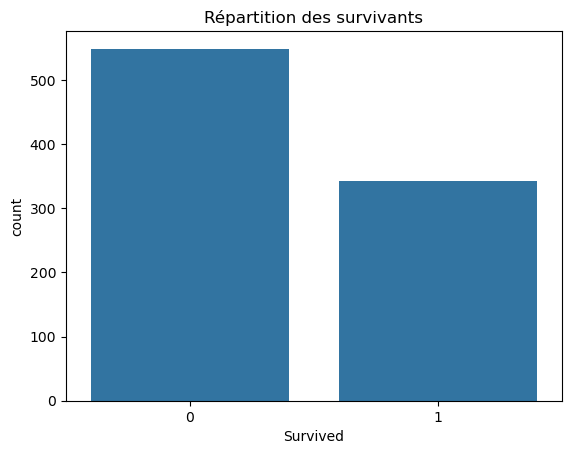

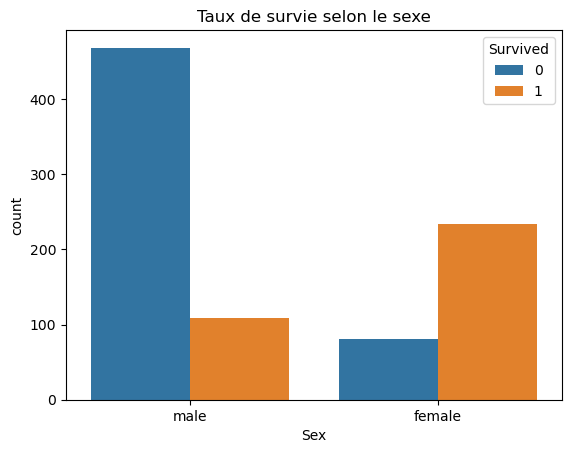

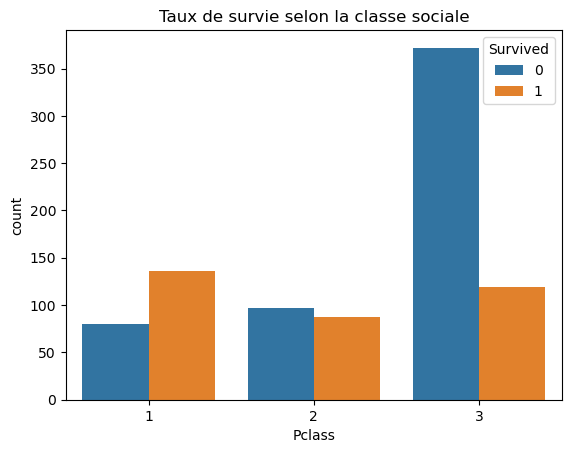

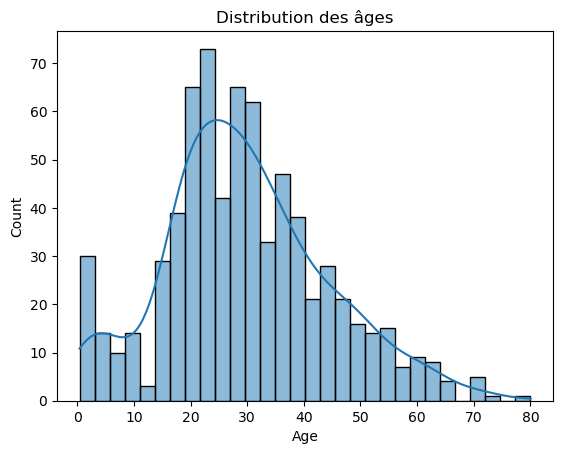

In [2]:
# Your EDA code here. 
# Examples: 
# - train_df.info()
# - train_df.describe()
# - sns.countplot(x='Survived', data=train_df)
# - sns.catplot(x='Sex', col='Survived', kind='count', data=train_df)
print("Informations sur les données :")
train_df.info()
print("\n")

# Statistiques de base
print("Aperçu statistique des colonnes numériques :")
print(train_df.describe())
print("\n")

# Valeurs manquantes
print("Valeurs manquantes dans le jeu d'entraînement :")
print(train_df.isnull().sum())

# Répartition de la variable cible
print("\nRépartition des survivants :")
print(train_df['Survived'].value_counts(normalize=True))

# Visualisations
sns.countplot(x='Survived', data=train_df)
plt.title("Répartition des survivants")
plt.show()

sns.countplot(x='Sex', hue='Survived', data=train_df)
plt.title("Taux de survie selon le sexe")
plt.show()

sns.countplot(x='Pclass', hue='Survived', data=train_df)
plt.title("Taux de survie selon la classe sociale")
plt.show()

sns.histplot(train_df['Age'].dropna(), bins=30, kde=True)
plt.title("Distribution des âges")
plt.show()

## 3. Data Cleaning & Feature Engineering

Based on our EDA, we'll clean the data by handling missing values and create new features to improve our model's performance.

In [7]:

def safe_fill_mode(df, col, default):
    if col not in df.columns:
        # crée la colonne si absente
        df[col] = default
        return
    non_na = df[col].dropna()
    if non_na.empty:
        df[col] = default
    else:
        df[col] = df[col].fillna(non_na.mode().iloc[0])

# --- Appliquer sur train/test ---
safe_fill_mode(train_df, 'Embarked', 'S')
safe_fill_mode(test_df,  'Embarked', 'S')

# Autres imputations (si besoin)
train_df['Age']  = train_df['Age'].fillna(train_df['Age'].median())
test_df['Age']   = test_df['Age'].fillna(test_df['Age'].median())
test_df['Fare']  = test_df['Fare'].fillna(test_df['Fare'].median())

# Normaliser puis encoder
for df in (train_df, test_df):
    # uniformiser le casing/espaces avant map
    df['Sex'] = df['Sex'].astype(str).str.strip().str.upper()
    df['Embarked'] = df['Embarked'].astype(str).str.strip().str.upper()

sex_map = {'MALE': 0, 'FEMALE': 1}
emb_map = {'S': 0, 'C': 1, 'Q': 2}

for df in (train_df, test_df):
    df['Sex'] = df['Sex'].map(sex_map)
    df['Embarked'] = df['Embarked'].map(emb_map)

    # si valeurs inattendues après map, remplace par la modalité majoritaire
    if df['Sex'].isna().any():
        df['Sex'] = df['Sex'].fillna(df['Sex'].mode().iloc[0] if not df['Sex'].dropna().empty else 0)
    if df['Embarked'].isna().any():
        df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode().iloc[0] if not df['Embarked'].dropna().empty else 0)

    df['Sex'] = df['Sex'].astype('int64')
    df['Embarked'] = df['Embarked'].astype('int64')

# Features dérivées
for df in (train_df, test_df):
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

# Sanity checks
features = ['Pclass','Sex','Age','Fare','FamilySize','IsAlone','Embarked']
missing_cols = [c for c in features if c not in train_df.columns]
assert not missing_cols, f"Colonnes manquantes: {missing_cols}"
assert not train_df[features].isnull().any().any(), "Il reste des NaN dans train_df[features]"


## 4. Model Training and Evaluation

It's time to choose a model, train it on our processed data, and see how well it performs.

In [8]:
# 4. Model Training & Evaluation (corrigé)
# ==============================

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer
import pandas as pd

# 1️⃣ Colonnes à utiliser
features = ['Pclass', 'Sex', 'Age', 'Fare', 'FamilySize', 'IsAlone', 'Embarked']

# Vérifier qu'elles existent toutes
available_features = [col for col in features if col in train_df.columns]
print("✅ Colonnes utilisées :", available_features)

# 2️⃣ Créer X et y
X = train_df[available_features]
y = train_df['Survived']

# 3️⃣ Gérer les valeurs manquantes
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)
X = pd.DataFrame(X_imputed, columns=available_features)

# 4️⃣ Diviser en train/validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 5️⃣ Entraîner le modèle
model = LogisticRegression(max_iter=1000, solver='liblinear')
model.fit(X_train, y_train)

# 6️⃣ Évaluer
y_pred = model.predict(X_val)
print("\n✅ Modèle entraîné avec succès !")
print("Accuracy :", round(accuracy_score(y_val, y_pred), 4))
print("\nMatrice de confusion :\n", confusion_matrix(y_val, y_pred))
print("\nRapport de classification :\n", classification_report(y_val, y_pred))

✅ Colonnes utilisées : ['Pclass', 'Sex', 'Age', 'Fare', 'FamilySize', 'IsAlone', 'Embarked']

✅ Modèle entraîné avec succès !
Accuracy : 0.7486

Matrice de confusion :
 [[97  8]
 [37 37]]

Rapport de classification :
               precision    recall  f1-score   support

           0       0.72      0.92      0.81       105
           1       0.82      0.50      0.62        74

    accuracy                           0.75       179
   macro avg       0.77      0.71      0.72       179
weighted avg       0.76      0.75      0.73       179



## 5. Create Submission File

Finally, we'll use our trained model to make predictions on the test set and generate the submission file in the required format.

In [ ]:
# Your submission generation code here.
# - Process the test_df in the same way as train_df
# - model.predict(X_test)
# - Create a submission DataFrame and save to 'submission.csv'